In [1]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Check the contents of your Google Drive root
print("Contents of Drive root:")
print(os.listdir('/content/drive'))

# Check contents of MyDrive
print("\nContents of MyDrive:")
print(os.listdir('/content/drive/MyDrive'))

Contents of Drive root:
['MyDrive', '.shortcut-targets-by-id', '.file-revisions-by-id', '.Trash-0', '.Encrypted']

Contents of MyDrive:
['chest_xray', 'Colab Notebooks', 'data', 'ocr_cheque.ipynb', 'beit-resnet.ipynb']


Main folders:
['test', 'train']

Folders in train:
['PNEUMONIA', 'NORMAL']

Folders in test:
['NORMAL', 'PNEUMONIA']

Train NORMAL images: 1352
Train PNEUMONIA images: 3876
Test NORMAL images: 234
Test PNEUMONIA images: 390


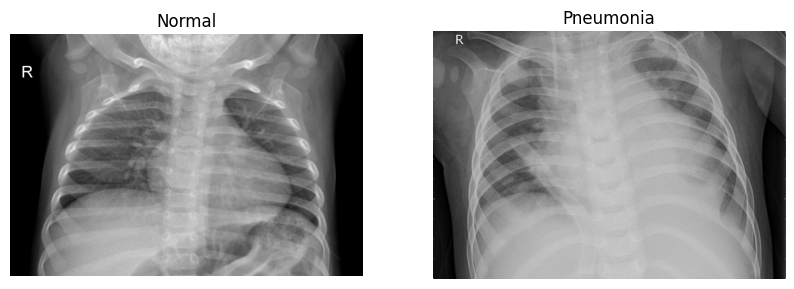

In [9]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = '/content/drive/MyDrive/chest_xray'

# Check the structure
print("Main folders:")
main_folders = os.listdir(dataset_path)
print(main_folders)

# Check contents of train folder
train_path = os.path.join(dataset_path, 'train')
train_folders = os.listdir(train_path)
print("\nFolders in train:")
print(train_folders)

# Check contents of test folder
test_path = os.path.join(dataset_path, 'test')
test_folders = os.listdir(test_path)
print("\nFolders in test:")
print(test_folders)

# Count images in each category
train_normal_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')

print(f"\nTrain NORMAL images: {len(os.listdir(train_normal_path))}")
print(f"Train PNEUMONIA images: {len(os.listdir(train_pneumonia_path))}")
print(f"Test NORMAL images: {len(os.listdir(test_normal_path))}")
print(f"Test PNEUMONIA images: {len(os.listdir(test_pneumonia_path))}")

# Display a sample image from each category
sample_normal = os.path.join(train_normal_path, os.listdir(train_normal_path)[0])
sample_pneumonia = os.path.join(train_pneumonia_path, os.listdir(train_pneumonia_path)[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(sample_normal), cmap='gray')
plt.title('Normal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Image.open(sample_pneumonia), cmap='gray')
plt.title('Pneumonia')
plt.axis('off')

plt.show()

model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import gc
import warnings
from tqdm import tqdm
from transformers import BeitModel, BeitConfig
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Improved configuration
CONFIG = {
    "data_dir" : "/content/drive/MyDrive/chest_xray",
    'batch_size': 2,
    'eval_batch_size': 4,
    'num_epochs': 100,
    'learning_rate': 0.00005,  # Lower learning rate for more stable fine-tuning
    'image_size': 192,
    'beit_model': "microsoft/beit-base-patch16-224-pt22k-ft22k",  # Using the finetuned model
    'use_mixed_precision': True,
    'gradient_accumulation_steps': 2,  # Effective batch size of 16
    'weight_decay': 0.02,  # Higher weight decay for better regularization
    'freeze_backbone_epochs': 0,  # Don't freeze backbone to improve recall
    'optimization_metric': 'f1',  # Optimize for F1 score (balances precision and recall)
    'focal_loss_gamma': 2.0,  # Focal loss gamma to focus more on hard examples
    'class_weight_normal': 2.0,  # Higher weight for the NORMAL class
    'class_weight_pneumonia': 1.0,
    'augmentation_strength': 'strong',  # Stronger augmentations to improve generalization
    'scheduler': 'cosine',  # Cosine annealing scheduler
    'use_checkpoint': False,  # Use checkpoint for model saving if available
    'patience': 7,  # Early stopping patience
    'warmup_epochs': 3,  # Warmup learning rate
    'resnet_pretrained': True,  # Use pretrained ResNet50
    'fusion_mode': 'concat',  # How to fuse BEiT and ResNet features (concat, add, attention)
    'fusion_dropout': 0.3,  # Dropout rate for feature fusion
    'resnet_unfreeze_layers': 2,  # Number of ResNet layers to fine-tune (0 = just the classifier, 4 = all layers)
}

# Device configuration
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Memory optimization for CUDA
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    torch.cuda.set_per_process_memory_fraction(0.75)  # Use only 75% of available memory
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

# Enhanced data transforms with stronger augmentations
def get_data_transforms(augmentation_strength='medium'):
    if augmentation_strength == 'strong':
        # Stronger augmentations for better generalization
        train_transform = transforms.Compose([
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),  # X-rays might be flipped
            transforms.RandomRotation(20),
            transforms.RandomAffine(
                degrees=20, translate=(0.15, 0.15),
                scale=(0.85, 1.15), shear=10),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.RandomAutocontrast(p=0.3),
            transforms.RandomEqualize(p=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
        ])
    elif augmentation_strength == 'medium':
        # Medium augmentations
        train_transform = transforms.Compose([
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1),
        ])
    else:
        # Light augmentations
        train_transform = transforms.Compose([
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # Validation transforms
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    return {
        'train': train_transform,
        'test': val_transform
    }

# Get data transforms
data_transforms = get_data_transforms(CONFIG.get('augmentation_strength', 'medium'))

# Focal Loss implementation for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Weight for each class
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Get CrossEntropyLoss
        ce_loss = F.cross_entropy(
            inputs, targets,
            weight=self.alpha,
            reduction='none'
        )

        # Get probabilities
        pt = torch.exp(-ce_loss)

        # Calculate focal loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Feature Fusion Module for combining ResNet and BEiT features
class FeatureFusionModule(nn.Module):
    def __init__(self, beit_dim, resnet_dim, fusion_mode='concat', dropout_rate=0.3):
        super(FeatureFusionModule, self).__init__()
        self.fusion_mode = fusion_mode

        if fusion_mode == 'concat':
            self.fused_dim = beit_dim + resnet_dim
            self.fusion = nn.Sequential(
                nn.Linear(self.fused_dim, self.fused_dim // 2),
                nn.LayerNorm(self.fused_dim // 2),
                nn.GELU(),
                nn.Dropout(dropout_rate)
            )
        elif fusion_mode == 'add':
            self.fused_dim = max(beit_dim, resnet_dim)
            # Project to same dimension if needed
            self.beit_proj = nn.Linear(beit_dim, self.fused_dim) if beit_dim != self.fused_dim else nn.Identity()
            self.resnet_proj = nn.Linear(resnet_dim, self.fused_dim) if resnet_dim != self.fused_dim else nn.Identity()
            self.fusion = nn.Sequential(
                nn.LayerNorm(self.fused_dim),
                nn.GELU(),
                nn.Dropout(dropout_rate)
            )
        elif fusion_mode == 'attention':
            self.fused_dim = max(beit_dim, resnet_dim)
            # Project to same dimension if needed
            self.beit_proj = nn.Linear(beit_dim, self.fused_dim) if beit_dim != self.fused_dim else nn.Identity()
            self.resnet_proj = nn.Linear(resnet_dim, self.fused_dim) if resnet_dim != self.fused_dim else nn.Identity()
            # Cross-attention mechanism
            self.query = nn.Linear(self.fused_dim, self.fused_dim)
            self.key = nn.Linear(self.fused_dim, self.fused_dim)
            self.value = nn.Linear(self.fused_dim, self.fused_dim)
            self.attention_norm = nn.LayerNorm(self.fused_dim)
            self.dropout = nn.Dropout(dropout_rate)
        else:
            raise ValueError(f"Unknown fusion mode: {fusion_mode}")

    def forward(self, beit_features, resnet_features):
        if self.fusion_mode == 'concat':
            # Concatenate features
            fused = torch.cat([beit_features, resnet_features], dim=1)
            return self.fusion(fused)
        elif self.fusion_mode == 'add':
            # Project to same dimension if needed
            beit_proj = self.beit_proj(beit_features)
            resnet_proj = self.resnet_proj(resnet_features)
            # Add features
            fused = beit_proj + resnet_proj
            return self.fusion(fused)
        elif self.fusion_mode == 'attention':
            # Project to same dimension if needed
            beit_proj = self.beit_proj(beit_features)
            resnet_proj = self.resnet_proj(resnet_features)

            # Cross-attention mechanism
            q = self.query(beit_proj)
            k = self.key(resnet_proj)
            v = self.value(resnet_proj)

            # Attention scores
            scores = torch.matmul(q.unsqueeze(1), k.unsqueeze(2)) / (self.fused_dim ** 0.5)
            attn_weights = F.softmax(scores, dim=2)
            attn_weights = self.dropout(attn_weights)

            # Apply attention
            context = torch.matmul(attn_weights, v.unsqueeze(2)).squeeze(2)

            # Residual connection and normalization
            fused = self.attention_norm(beit_proj + context)
            return fused

# Hybrid BEiT+ResNet50 model for pneumonia detection
class HybridBeitResNetClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.2, freeze_backbone=False):
        super(HybridBeitResNetClassifier, self).__init__()

        # Load pre-trained BEiT model with finetuned weights
        try:
            self.beit = BeitModel.from_pretrained(CONFIG['beit_model'])
            print(f"Successfully loaded BEiT model: {CONFIG['beit_model']}")
        except Exception as e:
            print(f"Error loading BEiT model: {e}")
            raise

        # Get BEiT feature dimension
        self.beit_feature_dim = self.beit.config.hidden_size
        print(f"BEiT feature dimension: {self.beit_feature_dim}")

        # Layer normalization for BEiT features
        self.beit_norm = nn.LayerNorm(self.beit_feature_dim)

        # Load pre-trained ResNet50
        self.resnet = models.resnet50(pretrained=CONFIG.get('resnet_pretrained', True))

        # Remove the final classification layer of ResNet
        self.resnet_feature_dim = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        print(f"ResNet50 feature dimension: {self.resnet_feature_dim}")

        # Freeze/unfreeze ResNet layers based on configuration
        self._set_resnet_gradients(CONFIG.get('resnet_unfreeze_layers', 2))

        # Feature fusion module
        self.fusion = FeatureFusionModule(
            beit_dim=self.beit_feature_dim,
            resnet_dim=self.resnet_feature_dim,
            fusion_mode=CONFIG.get('fusion_mode', 'concat'),
            dropout_rate=CONFIG.get('fusion_dropout', 0.3)
        )

        # Get fused dimension from fusion module
        fused_dim = self.fusion.fused_dim
        if CONFIG.get('fusion_mode', 'concat') == 'concat':
            fused_dim = fused_dim // 2  # Because fusion module reduces dimension for concat

        # Improved classifier with additional layers
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(fused_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

        # Initialize classifier weights
        self._init_classifier()

        # Option to freeze BEiT backbone
        self.freeze_backbone = freeze_backbone
        if freeze_backbone:
            self._freeze_beit_backbone()

    def _init_classifier(self):
        """Initialize classifier weights properly"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)

    def _set_resnet_gradients(self, unfreeze_layers=2):
        """Control which ResNet layers are trainable"""
        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze specific layers from the end
        if unfreeze_layers >= 1:  # Unfreeze layer4
            for param in self.resnet.layer4.parameters():
                param.requires_grad = True

        if unfreeze_layers >= 2:  # Unfreeze layer3
            for param in self.resnet.layer3.parameters():
                param.requires_grad = True

        if unfreeze_layers >= 3:  # Unfreeze layer2
            for param in self.resnet.layer2.parameters():
                param.requires_grad = True

        if unfreeze_layers >= 4:  # Unfreeze all layers including layer1 and earlier
            for param in self.resnet.parameters():
                param.requires_grad = True

    def _freeze_beit_backbone(self):
        """Freeze the BEiT backbone"""
        for param in self.beit.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        """Unfreeze the BEiT backbone"""
        for param in self.beit.parameters():
            param.requires_grad = True
        self.freeze_backbone = False

    def forward(self, x):
        # Extract features from BEiT with or without gradient
        if self.freeze_backbone:
            with torch.no_grad():
                beit_outputs = self.beit(x)
        else:
            beit_outputs = self.beit(x)

        # Get CLS token from BEiT
        beit_features = beit_outputs.last_hidden_state[:, 0]

        # Apply layer norm to BEiT features
        beit_features = self.beit_norm(beit_features)

        # Get ResNet features
        resnet_features = self.resnet(x)

        # Fuse features
        fused_features = self.fusion(beit_features, resnet_features)

        # Apply classifier
        logits = self.classifier(fused_features)

        return logits

def load_data():
    """Load pneumonia dataset with enhanced handling"""
    try:
        # Create image datasets
        image_datasets = {x: datasets.ImageFolder(
            os.path.join(CONFIG['data_dir'], x),
            data_transforms[x]
        ) for x in ['train', 'test']}

        # Get class names
        class_names = image_datasets['train'].classes
        print(f"Classes: {class_names}")

        # Print dataset info
        for split in ['train', 'test']:
            labels = [label for _, label in image_datasets[split].samples]
            unique_labels, counts = np.unique(labels, return_counts=True)
            print(f"{split} dataset:")
            for i, class_name in enumerate(class_names):
                class_count = counts[i] if i < len(counts) else 0
                print(f"  {class_name}: {class_count} images")

                # Calculate class imbalance ratio if both counts exist
                if len(counts) == 2:
                    imbalance_ratio = max(counts) / min(counts)
                    print(f"  Class imbalance ratio: {imbalance_ratio:.2f}")

        # Improved weighted sampler for handling class imbalance
        train_labels = np.array([label for _, label in image_datasets['train'].samples])

        # Calculate weights based on class frequencies
        class_counts = np.bincount(train_labels)

        # Enhanced weighting strategy
        weight_normal = CONFIG.get('class_weight_normal', 2.0)
        weight_pneumonia = CONFIG.get('class_weight_pneumonia', 1.0)
        class_weights = np.array([weight_normal, weight_pneumonia])
        print(f"Using class weights: {class_weights}")

        # Apply weights to samples
        weights = class_weights[train_labels]

        # Create balanced sampler
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=weights,
            num_samples=len(weights),
            replacement=True
        )

        # Create data loaders with enhanced settings
        dataloaders = {
            'train': torch.utils.data.DataLoader(
                image_datasets['train'],
                batch_size=CONFIG['batch_size'],
                sampler=sampler,
                num_workers=0,
                pin_memory=False,
                drop_last=True  # Avoid small last batches
            ),
            'test': torch.utils.data.DataLoader(
                image_datasets['test'],
                batch_size=CONFIG['eval_batch_size'],
                shuffle=False,
                num_workers=0,
                pin_memory=False
            )
        }

        dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
        print(f"Dataset sizes: {dataset_sizes}")

        return dataloaders, dataset_sizes, class_names

    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler=None, num_epochs=30):
    """Train the hybrid model with improved techniques"""
    since = time.time()

    # Set up checkpoint directory
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Best model tracking
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pt')
    best_acc = 0.0
    best_f1 = 0.0
    best_balanced = 0.0  # Track balanced metric (harmonic mean of sensitivity and specificity)

    # History tracking
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'val_specificity': [], 'val_sensitivity': [], 'val_balanced': []
    }

    # Gradient scaling for mixed precision
    scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_mixed_precision'])

    # Early stopping
    patience = CONFIG.get('patience', 7)
    counter = 0
    best_metric = 0.0

    # Gradient accumulation
    grad_accum_steps = CONFIG['gradient_accumulation_steps']

    # Learning rate warmup
    warmup_epochs = CONFIG.get('warmup_epochs', 0)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 30)

        # Unfreeze backbone if specified
        if epoch == CONFIG.get('freeze_backbone_epochs', 0) and model.freeze_backbone:
            print("Unfreezing backbone for fine-tuning...")
            model.unfreeze_backbone()
            # Adjust optimizer if needed
            if hasattr(optimizer, 'param_groups'):
                for param_group in optimizer.param_groups:
                    if 'beit' in param_group.get('name', ''):
                        param_group['lr'] = CONFIG['learning_rate'] * 0.1

        # Learning rate warmup
        if epoch < warmup_epochs and scheduler is None:
            # Manual warmup if no scheduler is provided
            warmup_factor = (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = CONFIG['learning_rate'] * warmup_factor

        # Each epoch has training and validation phases
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            # Reset gradient accumulation counter
            accum_step = 0

            # Process data with progress bar
            pbar = tqdm(dataloaders[phase], desc=phase)

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero gradients only when accumulation steps reached
                if phase == 'train' and accum_step % grad_accum_steps == 0:
                    optimizer.zero_grad()

                # Forward pass with mixed precision in training
                with torch.cuda.amp.autocast(enabled=CONFIG['use_mixed_precision']):
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        # Scale loss for gradient accumulation in training
                        if phase == 'train':
                            loss = loss / grad_accum_steps

                        # Get predictions
                        _, preds = torch.max(outputs, 1)

                        # Get probabilities for metrics
                        if phase == 'test':
                            probs = F.softmax(outputs, dim=1)

                        # Backward + optimize only in training phase
                        if phase == 'train':
                            # Use scaler for mixed precision
                            scaler.scale(loss).backward()

                            # Step optimizer if accumulation steps reached
                            if (accum_step + 1) % grad_accum_steps == 0:
                                # Unscale for gradient clipping
                                scaler.unscale_(optimizer)

                                # Clip gradients
                                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                                # Optimizer step with scaler
                                scaler.step(optimizer)
                                scaler.update()

                                # Step scheduler if provided
                                if scheduler is not None and epoch >= warmup_epochs:
                                    scheduler.step()

                            accum_step += 1

                # Statistics - scale loss back up for reporting
                if phase == 'train':
                    current_loss = loss.item() * inputs.size(0) * grad_accum_steps
                else:
                    current_loss = loss.item() * inputs.size(0)

                running_loss += current_loss

                # Collect predictions and labels
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                # Collect probabilities for AUC calculation
                if phase == 'test':
                    all_probs.extend(probs.cpu().numpy())

                # Update progress bar
                current_loss_avg = running_loss / ((pbar.n + 1) * inputs.size(0))
                pbar.set_postfix({'loss': f'{current_loss_avg:.4f}'})

                # Clean up memory
                del inputs, outputs, loss
                torch.cuda.empty_cache()

            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]

            # Calculate metrics
            all_labels = np.array(all_labels)
            all_preds = np.array(all_preds)

            epoch_acc = accuracy_score(all_labels, all_preds)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            else:
                # Calculate additional validation metrics
                try:
                    all_probs = np.array(all_probs)

                    # Calculate precision, recall, f1 for binary classification
                    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
                    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
                    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

                    # Calculate confusion matrix
                    cm = confusion_matrix(all_labels, all_preds)

                    # Extract confusion matrix values if it's the right shape
                    if cm.shape == (2, 2):
                        tn, fp, fn, tp = cm.ravel()
                        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                        sensitivity = recall  # Same as recall

                        # Calculate balanced metric (harmonic mean of sensitivity and specificity)
                        if sensitivity > 0 and specificity > 0:
                            balanced = 2 * (sensitivity * specificity) / (sensitivity + specificity)
                        else:
                            balanced = 0
                    else:
                        specificity = 0
                        sensitivity = recall
                        balanced = 0

                    # Calculate AUC if we have probabilities
                    try:
                        pneumonia_auc = roc_auc_score(all_labels, all_probs[:, 1])
                    except:
                        pneumonia_auc = 0

                    # Store validation metrics
                    history['val_loss'].append(epoch_loss)
                    history['val_acc'].append(epoch_acc)
                    history['val_precision'].append(precision)
                    history['val_recall'].append(recall)
                    history['val_f1'].append(f1)
                    history['val_specificity'].append(specificity)
                    history['val_sensitivity'].append(sensitivity)
                    history['val_balanced'].append(balanced)

                    # Print detailed metrics
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                    print(f'Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')
                    print(f'Specificity: {specificity:.4f} AUC: {pneumonia_auc:.4f}')
                    print(f'Balanced Metric: {balanced:.4f}')

                    if cm.shape == (2, 2):
                        print(f'Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}')

                    # Choose optimization metric based on configuration
                    optimization_metric = CONFIG.get('optimization_metric', 'f1')
                    if optimization_metric == 'f1':
                        current_metric = f1
                    elif optimization_metric == 'balanced':
                        current_metric = balanced
                    elif optimization_metric == 'recall':
                        current_metric = recall
                    else:
                        current_metric = f1

                    # Check if this is the best model
                    improved = False
                    if current_metric > best_metric:
                        best_metric = current_metric
                        improved = True
                        metric_name = optimization_metric

                    # Save best metrics independently as well
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                    if f1 > best_f1:
                        best_f1 = f1
                    if balanced > best_balanced:
                        best_balanced = balanced

                    if improved:
                        counter = 0
                        print(f"Saving best model (improved {metric_name}: {current_metric:.4f})")

                        # Save model checkpoint
                        torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'metrics': {
                                'accuracy': epoch_acc,
                                'precision': precision,
                                'recall': recall,
                                'f1': f1,
                                'specificity': specificity,
                                'sensitivity': sensitivity,
                                'balanced': balanced,
                                'auc': pneumonia_auc,
                                'confusion_matrix': cm.tolist()
                            },
                            'history': history
                        }, best_model_path)

                        # Also save epoch-specific checkpoint for potential ensemble
                        torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'metrics': {
                                'accuracy': epoch_acc,
                                'f1': f1,
                                'balanced': balanced
                            }
                        }, os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))
                    else:
                        counter += 1
                        print(f"Early stopping counter: {counter}/{patience}")

                except Exception as e:
                    import traceback
                    print(f"Error calculating metrics: {e}")
                    traceback.print_exc()

            # Clean memory after each phase
            torch.cuda.empty_cache()
            gc.collect()

        # Check for early stopping
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print()

    # Calculate training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best metrics: Acc: {best_acc:.4f}, F1: {best_f1:.4f}, Balanced: {best_balanced:.4f}')

    # Load best model weights
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_metrics = checkpoint.get('metrics', {})
        print("Loaded best model from checkpoint")

        # Print best model metrics
        if best_metrics:
            print("\nBest model metrics:")
            for k, v in best_metrics.items():
                if k != 'confusion_matrix':
                    print(f"  {k}: {v:.4f}")

    return model, history

def plot_training_results(history):
    """Plot enhanced training curves with more metrics"""
    plt.figure(figsize=(20, 10))

    # Plot accuracy
    plt.subplot(2, 3, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # Plot loss
    plt.subplot(2, 3, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    # Plot precision, recall, f1
    plt.subplot(2, 3, 3)
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.plot(history['val_f1'], label='F1 Score')
    plt.title('Precision, Recall, and F1 Score')
    plt.ylabel('Score')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # Plot sensitivity and specificity
    plt.subplot(2, 3, 4)
    plt.plot(history['val_sensitivity'], label='Sensitivity')
    plt.plot(history['val_specificity'], label='Specificity')
    plt.plot(history['val_balanced'], label='Balanced Metric')
    plt.title('Sensitivity and Specificity')
    plt.ylabel('Score')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # Plot recall vs precision for threshold tuning
    plt.subplot(2, 3, 5)

    # Extract metrics with matching epochs
    epochs = range(1, len(history['val_recall']) + 1)
    plt.scatter(history['val_recall'], history['val_precision'], c=epochs, cmap='viridis')
    plt.colorbar(label='Epoch')

    # Add annotations for some points
    for i, epoch in enumerate(epochs):
        if i % 5 == 0 or i == len(epochs) - 1:  # Annotate every 5th epoch and last epoch
            plt.annotate(
                f'{epoch}',
                (history['val_recall'][i], history['val_precision'][i]),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center'
            )

    plt.title('Precision vs Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('hybrid_beit_resnet_pneumonia_training_results.png', dpi=300)

def evaluate_model(model, dataloader, class_names):
    """Enhanced evaluation for pneumonia detection"""
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    # Collect predictions
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)

            # Use mixed precision for inference
            with torch.cuda.amp.autocast(enabled=CONFIG['use_mixed_precision']):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                probs = F.softmax(outputs, dim=1)

            # Collect results
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Clean memory
            del inputs, outputs, preds, probs
            torch.cuda.empty_cache()

    # Convert to arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate standard metrics
    accuracy = accuracy_score(all_labels, all_preds)

    # Precision, recall, f1 for binary classification
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # ROC AUC
    try:
        roc_auc = roc_auc_score(all_labels, all_probs[:, 1])
    except:
        roc_auc = 0

    # Extract metrics from confusion matrix
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = recall  # Same as recall

        # Positive and negative predictive values
        ppv = precision  # Same as precision
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        # Balanced accuracy
        balanced_acc = (sensitivity + specificity) / 2

        # Harmonic mean of sensitivity and specificity
        if sensitivity > 0 and specificity > 0:
            balanced_f = 2 * (sensitivity * specificity) / (sensitivity + specificity)
        else:
            balanced_f = 0
    else:
        tn, fp, fn, tp = 0, 0, 0, 0
        specificity = 0
        sensitivity = 0
        ppv = 0
        npv = 0
        balanced_acc = 0
        balanced_f = 0

    # Find optimal threshold for better sensitivity-specificity balance
    # Only if we have enough data of both classes
    thresholds = []
    sensitivities = []
    specificities = []
    balanced_metrics = []
    optimal_threshold = 0.5
    best_balanced = 0

    try:
        if len(np.unique(all_labels)) > 1:
            pneumonia_probs = all_probs[:, 1]

            # Try different thresholds
            for threshold in np.arange(0.1, 0.9, 0.05):
                custom_preds = (pneumonia_probs >= threshold).astype(int)

                # Calculate confusion matrix for this threshold
                cm_custom = confusion_matrix(all_labels, custom_preds)

                if cm_custom.shape == (2, 2):
                    tn_t, fp_t, fn_t, tp_t = cm_custom.ravel()

                    # Calculate metrics for this threshold
                    spec_t = tn_t / (tn_t + fp_t) if (tn_t + fp_t) > 0 else 0
                    sens_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0

                    # Balanced metric (harmonic mean)
                    if sens_t > 0 and spec_t > 0:
                        balanced_t = 2 * (sens_t * spec_t) / (sens_t + spec_t)
                    else:
                        balanced_t = 0

                    # Store results
                    thresholds.append(threshold)
                    sensitivities.append(sens_t)
                    specificities.append(spec_t)
                    balanced_metrics.append(balanced_t)

                    # Update optimal threshold if this is better
                    if balanced_t > best_balanced:
                        optimal_threshold = threshold
                        best_balanced = balanced_t
    except Exception as e:
        print(f"Error in threshold optimization: {e}")

    # Print metrics
    print("\n===== ENHANCED MODEL EVALUATION =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Harmonic Mean (Sensitivity-Specificity): {balanced_f:.4f}")

    print("\nConfusion Matrix:")
    print(f"  True Negatives: {tn}, False Positives: {fp}")
    print(f"  False Negatives: {fn}, True Positives: {tp}")

    print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
    print(f"  At this threshold - Sensitivity: {best_balanced:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                   horizontalalignment="center", fontsize=12,
                   color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('hybrid_beit_resnet_pneumonia_cm.png', dpi=200)

    # Plot ROC curve
    if len(np.unique(all_labels)) > 1:
        from sklearn.metrics import roc_curve
        plt.figure(figsize=(8, 6))

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])

        # Plot ROC curve
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

        # Mark optimal threshold
        if thresholds:
            # Find index of optimal threshold
            idx = thresholds.index(optimal_threshold) if optimal_threshold in thresholds else -1
            if idx >= 0 and idx < len(sensitivities):
                # Get false positive rate and true positive rate for optimal threshold
                optimal_sens = sensitivities[idx]
                optimal_spec = specificities[idx]
                optimal_fpr = 1 - optimal_spec

                # Mark on the plot
                plt.plot(optimal_fpr, optimal_sens, 'ro', markersize=8,
                         label=f'Optimal threshold: {optimal_threshold:.2f}')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.savefig('hybrid_beit_resnet_pneumonia_roc.png', dpi=200)

    # Plot precision-recall curve
    if len(np.unique(all_labels)) > 1:
        from sklearn.metrics import precision_recall_curve, average_precision_score

        # Calculate precision-recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs[:, 1])

        # Calculate average precision
        avg_precision = average_precision_score(all_labels, all_probs[:, 1])

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(recall_curve, precision_curve, color='blue', lw=2,
                 label=f'AP = {avg_precision:.3f}')

        # Mark optimal threshold on PR curve
        if thresholds:
            # Find the closest threshold
            idx = thresholds.index(optimal_threshold) if optimal_threshold in thresholds else -1
            if idx >= 0 and idx < len(sensitivities):
                optimal_sens = sensitivities[idx]
                optimal_prec = precision_score(all_labels, (all_probs[:, 1] >= optimal_threshold).astype(int),
                                               zero_division=0)

                # Mark on the plot
                plt.plot(optimal_sens, optimal_prec, 'ro', markersize=8,
                         label=f'Optimal threshold: {optimal_threshold:.2f}')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall (Sensitivity)')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(alpha=0.3)
        plt.savefig('hybrid_beit_resnet_pneumonia_pr_curve.png', dpi=200)

    # Return comprehensive metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'balanced_accuracy': balanced_acc,
        'balanced_f': balanced_f,
        'auc': roc_auc,
        'ppv': ppv,
        'npv': npv,
        'confusion_matrix': cm,
        'optimal_threshold': optimal_threshold,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp
    }

def main():
    try:
        print("=== Hybrid BEiT+ResNet50 Pneumonia Detection ===")

        # Load pneumonia dataset
        print("Loading pneumonia X-ray dataset...")
        dataloaders, dataset_sizes, class_names = load_data()

        # Create hybrid BEiT+ResNet50 model
        print("Creating hybrid BEiT+ResNet50 model...")
        model = HybridBeitResNetClassifier(
            num_classes=len(class_names),
            dropout_rate=0.2,
            freeze_backbone=CONFIG.get('freeze_backbone_epochs', 0) > 0
        )
        model = model.to(device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        # Create loss function with class weights
        if CONFIG.get('use_focal_loss', True):
            # Create class weights tensor for focal loss
            weights = torch.tensor([
                CONFIG.get('class_weight_normal', 2.0),
                CONFIG.get('class_weight_pneumonia', 1.0)
            ]).float().to(device)

            # Focal loss for handling class imbalance
            criterion = FocalLoss(
                gamma=CONFIG.get('focal_loss_gamma', 2.0),
                alpha=weights
            )
            print(f"Using Focal Loss (gamma={CONFIG.get('focal_loss_gamma', 2.0)}) with class weights {weights.tolist()}")
        else:
            # Standard cross entropy with class weights
            weights = torch.tensor([
                CONFIG.get('class_weight_normal', 2.0),
                CONFIG.get('class_weight_pneumonia', 1.0)
            ]).float().to(device)

            criterion = nn.CrossEntropyLoss(weight=weights)
            print(f"Using Cross Entropy Loss with class weights {weights.tolist()}")

        # Create optimizer with weight decay
        optimizer = optim.AdamW(
            model.parameters(),
            lr=CONFIG['learning_rate'],
            weight_decay=CONFIG.get('weight_decay', 0.01),
            eps=1e-8  # Higher epsilon for numerical stability
        )

        # Create scheduler
        if CONFIG.get('scheduler', 'cosine') == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=CONFIG['num_epochs'],
                eta_min=CONFIG['learning_rate'] * 0.001
            )
            print("Using Cosine Annealing scheduler")
        else:
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=0.5,
                patience=5,
                verbose=True
            )
            print("Using ReduceLROnPlateau scheduler")

        # Check if we should try to load a previous checkpoint
        if CONFIG.get('use_checkpoint', False):
            checkpoint_path = 'checkpoints/best_model.pt'
            if os.path.exists(checkpoint_path):
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint.get('epoch', 0) + 1
                print(f"Loaded checkpoint from epoch {start_epoch-1}")

                # Print metrics from checkpoint
                if 'metrics' in checkpoint:
                    print("Checkpoint metrics:")
                    for k, v in checkpoint['metrics'].items():
                        if k != 'confusion_matrix':
                            print(f"  {k}: {v:.4f}")

                # Ask for confirmation before continuing training
                confirmation = input("Continue training from checkpoint? (y/n): ")
                if confirmation.lower() != 'y':
                    print("Starting fresh training...")
                    # Create fresh model
                    model = HybridBeitResNetClassifier(
                        num_classes=len(class_names),
                        dropout_rate=0.2,
                        freeze_backbone=CONFIG.get('freeze_backbone_epochs', 0) > 0
                    )
                    model = model.to(device)

                    # Create fresh optimizer
                    optimizer = optim.AdamW(
                        model.parameters(),
                        lr=CONFIG['learning_rate'],
                        weight_decay=CONFIG.get('weight_decay', 0.01),
                        eps=1e-8
                    )

        # Train model
        print("Starting hybrid model training with enhanced techniques...")
        model, history = train_model(
            model, dataloaders, dataset_sizes, criterion, optimizer, scheduler,
            num_epochs=CONFIG['num_epochs']
        )

        # Plot results
        plot_training_results(history)

        # Comprehensive evaluation
        print("Performing comprehensive evaluation...")
        metrics = evaluate_model(model, dataloaders['test'], class_names)

        # Save model
        print("Saving hybrid model...")
        model = model.to('cpu')  # Move to CPU for saving
        torch.save({
            'model_state_dict': model.state_dict(),
            'class_names': class_names,
            'config': CONFIG,
            'metrics': metrics,
            'history': history
        }, 'hybrid_beit_resnet_pneumonia_model.pth')

        print("Model saved to 'hybrid_beit_resnet_pneumonia_model.pth'")

        # Create example usage code
        usage_code = """
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import BeitModel
import numpy as np
import torchvision.models as models

# Load the model
def load_hybrid_model(model_path):
    # Define the feature fusion module
    class FeatureFusionModule(nn.Module):
        def __init__(self, beit_dim, resnet_dim, fusion_mode='concat', dropout_rate=0.3):
            super(FeatureFusionModule, self).__init__()
            self.fusion_mode = fusion_mode

            if fusion_mode == 'concat':
                self.fused_dim = beit_dim + resnet_dim
                self.fusion = nn.Sequential(
                    nn.Linear(self.fused_dim, self.fused_dim // 2),
                    nn.LayerNorm(self.fused_dim // 2),
                    nn.GELU(),
                    nn.Dropout(dropout_rate)
                )
            elif fusion_mode == 'add':
                self.fused_dim = max(beit_dim, resnet_dim)
                # Project to same dimension if needed
                self.beit_proj = nn.Linear(beit_dim, self.fused_dim) if beit_dim != self.fused_dim else nn.Identity()
                self.resnet_proj = nn.Linear(resnet_dim, self.fused_dim) if resnet_dim != self.fused_dim else nn.Identity()
                self.fusion = nn.Sequential(
                    nn.LayerNorm(self.fused_dim),
                    nn.GELU(),
                    nn.Dropout(dropout_rate)
                )
            elif fusion_mode == 'attention':
                self.fused_dim = max(beit_dim, resnet_dim)
                # Project to same dimension if needed
                self.beit_proj = nn.Linear(beit_dim, self.fused_dim) if beit_dim != self.fused_dim else nn.Identity()
                self.resnet_proj = nn.Linear(resnet_dim, self.fused_dim) if resnet_dim != self.fused_dim else nn.Identity()
                # Cross-attention mechanism
                self.query = nn.Linear(self.fused_dim, self.fused_dim)
                self.key = nn.Linear(self.fused_dim, self.fused_dim)
                self.value = nn.Linear(self.fused_dim, self.fused_dim)
                self.attention_norm = nn.LayerNorm(self.fused_dim)
                self.dropout = nn.Dropout(dropout_rate)

        def forward(self, beit_features, resnet_features):
            if self.fusion_mode == 'concat':
                # Concatenate features
                fused = torch.cat([beit_features, resnet_features], dim=1)
                return self.fusion(fused)
            elif self.fusion_mode == 'add':
                # Project to same dimension if needed
                beit_proj = self.beit_proj(beit_features)
                resnet_proj = self.resnet_proj(resnet_features)
                # Add features
                fused = beit_proj + resnet_proj
                return self.fusion(fused)
            elif self.fusion_mode == 'attention':
                # Project to same dimension if needed
                beit_proj = self.beit_proj(beit_features)
                resnet_proj = self.resnet_proj(resnet_features)

                # Cross-attention mechanism
                q = self.query(beit_proj)
                k = self.key(resnet_proj)
                v = self.value(resnet_proj)

                # Attention scores
                scores = torch.matmul(q.unsqueeze(1), k.unsqueeze(2)) / (self.fused_dim ** 0.5)
                attn_weights = torch.nn.functional.softmax(scores, dim=2)
                attn_weights = self.dropout(attn_weights)

                # Apply attention
                context = torch.matmul(attn_weights, v.unsqueeze(2)).squeeze(2)

                # Residual connection and normalization
                fused = self.attention_norm(beit_proj + context)
                return fused

    # Define the hybrid model class
    class HybridBeitResNetClassifier(nn.Module):
        def __init__(self, num_classes=2, dropout_rate=0.2):
            super(HybridBeitResNetClassifier, self).__init__()

            # Load BEiT
            self.beit = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
            self.beit_feature_dim = self.beit.config.hidden_size
            self.beit_norm = nn.LayerNorm(self.beit_feature_dim)

            # Load ResNet50
            self.resnet = models.resnet50(pretrained=False)
            self.resnet_feature_dim = self.resnet.fc.in_features
            self.resnet.fc = nn.Identity()

            # Feature fusion
            self.fusion = FeatureFusionModule(
                beit_dim=self.beit_feature_dim,
                resnet_dim=self.resnet_feature_dim,
                fusion_mode='concat',
                dropout_rate=0.3
            )

            fused_dim = self.fusion.fused_dim
            if 'concat' == 'concat':
                fused_dim = fused_dim // 2

            # Classifier
            self.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(fused_dim, 512),
                nn.GELU(),
                nn.LayerNorm(512),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256),
                nn.GELU(),
                nn.LayerNorm(256),
                nn.Dropout(dropout_rate),
                nn.Linear(256, num_classes)
            )

        def forward(self, x):
            # BEiT features
            beit_outputs = self.beit(x)
            beit_features = beit_outputs.last_hidden_state[:, 0]
            beit_features = self.beit_norm(beit_features)

            # ResNet features
            resnet_features = self.resnet(x)

            # Fuse features
            fused_features = self.fusion(beit_features, resnet_features)

            # Classification
            logits = self.classifier(fused_features)
            return logits

    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')

    # Create model and load weights
    model = HybridBeitResNetClassifier(num_classes=len(checkpoint['class_names']))

    (num_classes=len(checkpoint['class_names']))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, checkpoint

# Function to predict on a single image
def predict_pneumonia(model, image_path, checkpoint):
    # Set up transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]

        # Get pneumonia probability
        pneumonia_idx = 1  # Assuming PNEUMONIA is class 1
        pneumonia_probability = probabilities[pneumonia_idx].item()

        # Use optimal threshold from metrics if available
        optimal_threshold = checkpoint.get('metrics', {}).get('optimal_threshold', 0.5)
        predicted_class = pneumonia_idx if pneumonia_probability >= optimal_threshold else 0

    # Get class name and probability
    class_name = checkpoint['class_names'][predicted_class]
    probability = pneumonia_probability if predicted_class == pneumonia_idx else 1 - pneumonia_probability
    probability *= 100  # Convert to percentage

    # Display results
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    title = f"Prediction: {class_name} ({probability:.1f}%)"
    if pneumonia_probability >= 0.5 and pneumonia_probability < optimal_threshold:
        title += f"\\nNote: Standard threshold would predict PNEUMONIA"
    elif pneumonia_probability < 0.5 and pneumonia_probability >= optimal_threshold:
        title += f"\\nNote: Standard threshold would predict NORMAL"

    plt.title(title)
    plt.axis('off')

    # Add probability bars
    plt.figure(figsize=(8, 2))
    bars = plt.bar(
        checkpoint['class_names'],
        [1-pneumonia_probability, pneumonia_probability],
        color=['green', 'red']
    )
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Class Probabilities')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height*100:.1f}%',
            ha='center', va='bottom'
        )

    plt.tight_layout()
    plt.show()

    return {
        'class': class_name,
        'probability': probability,
        'pneumonia_probability': pneumonia_probability * 100,
        'normal_probability': (1 - pneumonia_probability) * 100,
        'threshold_used': optimal_threshold
    }

# Example usage
model, checkpoint = load_hybrid_model('hybrid_beit_resnet_pneumonia_model.pth')
result = predict_pneumonia(model, 'path/to/your/xray.jpg', checkpoint)
print(f"Prediction: {result['class']} with {result['probability']:.1f}% confidence")
print(f"Probability of pneumonia: {result['pneumonia_probability']:.1f}%")
print(f"Probability of normal: {result['normal_probability']:.1f}%")
print(f"Using threshold: {result['threshold_used']:.2f}")
        """

        with open('use_hybrid_pneumonia_model.py', 'w') as f:
            f.write(usage_code)

        print("Usage code saved to use_hybrid_pneumonia_model.py")

    except Exception as e:
        import traceback
        print(f"Error in main: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()

Using device: cpu
=== Hybrid BEiT+ResNet50 Pneumonia Detection ===
Loading pneumonia X-ray dataset...
Classes: ['NORMAL', 'PNEUMONIA']
train dataset:
  NORMAL: 1351 images
  Class imbalance ratio: 2.87
  PNEUMONIA: 3875 images
  Class imbalance ratio: 2.87
test dataset:
  NORMAL: 234 images
  Class imbalance ratio: 1.67
  PNEUMONIA: 390 images
  Class imbalance ratio: 1.67
Using class weights: [2. 1.]
Dataset sizes: {'train': 5226, 'test': 624}
Creating hybrid BEiT+ResNet50 model...


config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/414M [00:00<?, ?B/s]

Successfully loaded BEiT model: microsoft/beit-base-patch16-224-pt22k-ft22k
BEiT feature dimension: 768


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
  4%|▍         | 3.88M/97.8M [00:00<00:02, 38.8MB/s]
  9%|▉         | 8.75M/97.8M [00:00<00:02, 45.9MB/s]
 14%|█▎        | 13.2M/97.8M [00:00<00:02, 40.7MB/s]
 18%|█▊        | 17.2M/97.8M [00:00<00:02, 40.4MB/s]
 22%|██▏       | 21.2M/97.8M [00:00<00:02, 39.0MB/s]
 26%|██▌       | 25.0M/97.8M [00:02<00:13, 5.67MB/s]
 28%|██▊       | 27.6M/97.8M [00:02<00:11, 6.36MB/s]
 35%|███▍      | 34.0M/97.8M [00:02<00:06, 10.8MB/s]
 43%|████▎     | 42.5M/97.8M [00:03<00:03, 18.2MB/s]
 52%|█████▏    | 50.8M/97.8M [00:03<00:01, 26.3MB/s]
 58%|█████▊    | 56.8M/97.8M [00:03<00:01, 31.3MB/s]
 64%|██████▍   | 62.6M/97.8M [00:03<00:01, 35.5MB/s]
 70%|██████▉   | 68.2M/97.8M [00:03<00:00, 38.1MB/s]
 75%|███████▌  | 73.6M/97.8M [00:03<00:00, 40.5MB/s]
 82%|████████▏ | 80.0M/97.8M [00:03<00:00, 46.2MB/s]
 90%|████████▉ | 87.6M/97.8

ResNet50 feature dimension: 2048
Total parameters: 114,095,490
Trainable parameters: 112,650,562
Using Focal Loss (gamma=2.0) with class weights [2.0, 1.0]
Using Cosine Annealing scheduler
Starting hybrid model training with enhanced techniques...
Epoch 0/99
------------------------------


train:   0%|          | 13/2613 [01:13<4:01:53,  5.58s/it, loss=0.6542]